In [3]:
import numpy as np
import pandas as pd
import umap

from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from scipy import  stats

from IPython.display import Image

import plotly.graph_objs as go
import plotly.io as pio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv('df/6_clear.csv')

### Interactive plot

For statistical analysis of data we can calculate metrics such as mean, standard Deviation (STD), median, mode, quartiles, interquartile range (IQR). We choose the refractive index column for analysis, as this value is assumed for further prediction.


In [4]:
mean = df['raw_value'].mean()
std = df['raw_value'].std()
median = np.median(df['raw_value'])
mode = stats.mode(df['raw_value'], keepdims=False).mode
quartiles = np.quantile(df['raw_value'], [0.25, 0.5, 0.75])
irq = stats.iqr(df['raw_value'])
print("Mean:", mean)
print("STD:", std)
print("Median:", median)
print("Mode:", mode)
print("Quartiles:", quartiles)
print("IRQ:", irq)

Mean: 1.7947097996265173
STD: 0.6154339947171551
Median: 1.5295
Mode: 3.0
Quartiles: [1.423275 1.5295   1.96    ]
IRQ: 0.5367250000000001


Let's build a histogram in order to evaluate the symmetry of the data and present the results of the statistical analysis

In [5]:
y_max = 0.25

fig_data = [
            go.Scatter(x=[mean]*2,
                       y = [0, y_max],
                       name="mean",
                       marker_color="#86A69D"),
            go.Scatter(x=[median]*2,
                       y = [0, y_max],
                       name="median",
                       marker_color="#F2B263"),
            go.Scatter(x=[mode]*2,
                       y = [0, y_max],
                       name="mode",
                       marker_color="#BB916C"),
            go.Scatter(y=[0.01]*2,
                       x = [quartiles[0], quartiles[-1]],
                       name="IRQ",
                       marker_color="#F28585"),
            go.Histogram(x=df['raw_value'], 
                         histnorm='probability',
                       marker_color="#F2C6C2",
                       name="raw_value",)
            ]

layout = go.Layout(xaxis={"dtick": 1},
                   barmode="stack")
fig = go.Figure(data=fig_data,
                layout=layout)

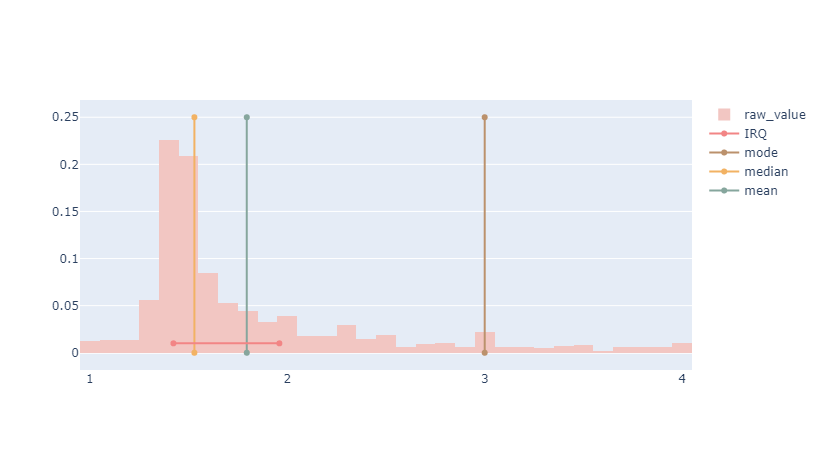

In [6]:
image = 'fig/hist.png'
Image(filename=image, width=600)

In [7]:
pio.write_html(fig, file='histogram.html', auto_open=True)

You can see from the figure that the distribution is not symmetrical and is heavily skewed toward the beginning of the distribution. The mismatch between the mean and the median is also indicative of asymmetry.

Let's build a boxplot since it reflects well the compressed information about the distribution statistics of the available data.


In [8]:
fig_data = [go.Box(y = df['raw_value'],
                   q1=[quartiles[0]], 
                   median=[quartiles[1]],
                   q3=[quartiles[2]], 
                   lowerfence=[df['raw_value'].min()],
                   upperfence=[df['raw_value'].max()], 
                   mean=[mean],
                   sd=[std],
                   marker_color="#F28585"
                  )
           ]
layout = go.Layout(xaxis={"dtick": 1})
fig = go.Figure(data=fig_data,
                layout=layout)

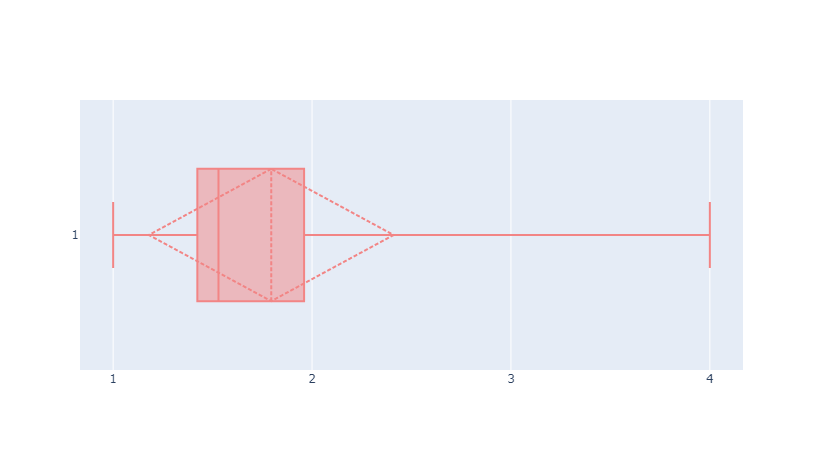

In [9]:
image = 'fig/box.png'
Image(filename=image, width=600)

In [10]:
pio.write_html(fig, file='boxplot.html', auto_open=True)

From the boxplot we see that the STD covers a wide range, and the data is heavily skewed toward the low values.

### Other statistical plots

One common type of plots, are those that reflect the composition of the dataset. For example, we can use a pie chart to show the number of samples measured by each method.

([<matplotlib.patches.Wedge at 0x1a3efef6800>,
 [Text(0.26360868848889846, 1.0679468429435817, 'el_mylogic'),
  Text(-0.9070410664823909, -0.6223154374708113, 'el_cde_tables'),
  Text(0.34727527620346016, -1.0437432071816375, 'rsc_cde_tables'),
  Text(0.7302706740567392, -0.8226206553525847, 'el_cde_text'),
  Text(0.9501988120632329, -0.5541860856730538, 'rsc_cde_text'),
  Text(1.0492099082286255, -0.33039153814055106, 'snowball'),
  Text(1.0895626502360647, -0.15117285209508774, 'rsc_mylogic'),
  Text(1.098467060453667, -0.05805270965493583, 'springer_cde_table'),
  Text(1.0998816941023937, -0.016132544078617486, 'springer_cde_text')])

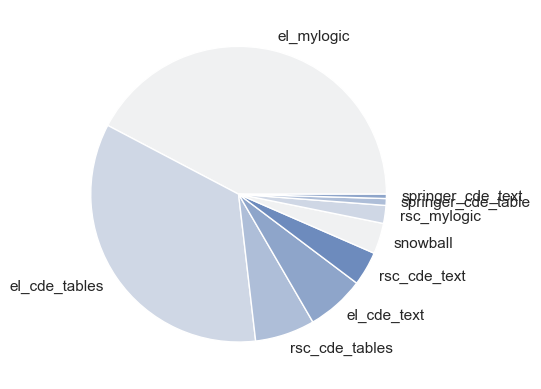

In [11]:
# define Seaborn color palette to use
colors = sns.color_palette('light:b')[ 0:5 ]

# let's build a pie plot
plt.pie(df['measurement_method'].value_counts().values, labels=df['measurement_method'].value_counts().index, colors = colors)

As we can see, in most cases 'el_mylogic' or 'el_cde_tables' were used as the measurement method. 

Let's create a figure showing the dependence of the two parameters of molecular weight and polar surface area. This will also reflect the dependence on the complexity of the structure and the number of heavy atoms.

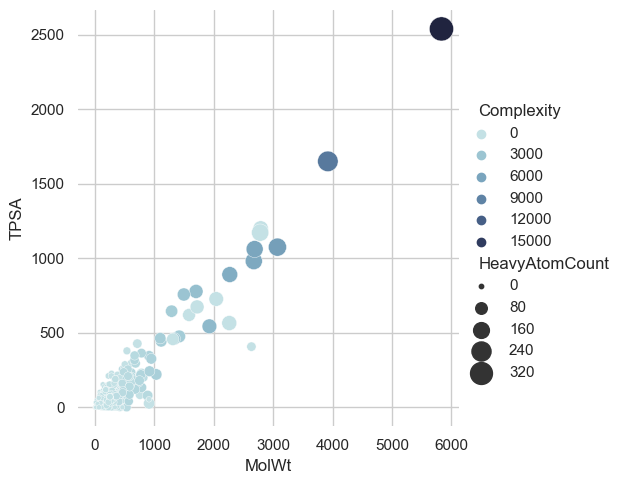

In [12]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df,
    x='MolWt', y='TPSA',
    hue='Complexity', size='HeavyAtomCount',
    palette=cmap, sizes=(10, 300),
)
g.despine(left=True, bottom=True)

As we can see, there is a strong linear dependence of surface area on molecular weight, which is logical from a chemical point of view. The same dependence is also observed for the complexity of the structure and the number of heavy atoms. As the molecular weight increases, the surface area, structure complexity, and number of heavy atoms in it increase.

To build a plot reflecting the distribution of the data, let's build a violin plot. To do this, convert one of the parameters into a categorical one.

In [ ]:
# set a new column for the categorical feature and divide the samples into three categories
df['Charge_categorical'] = np.nan

for num in range(len(df['Charge'])):
    if df['Charge'][num] < 0:
        df['Charge_categorical'][num] = 'Negative'
    elif df['Charge'][num] > 0:
        df['Charge_categorical'][num] = 'Positive'
    elif df['Charge'][num] == 0:
        df['Charge_categorical'][num] = 'Neutral'

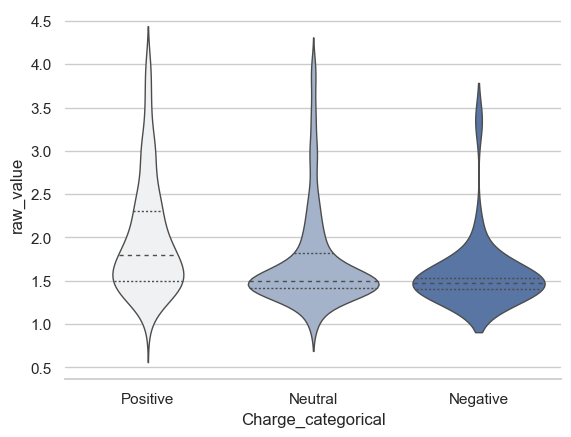

In [14]:
# let's build a violin plot
sns.violinplot(data=df, x='Charge_categorical', y='raw_value', palette="light:b",
                 inner="quart", linewidth=1)
sns.despine(left=True)

Based on the figure, we can say that the samples with neutral or negative charge have similar distributions. At the same time, positively charged samples have a higher value of refractive index, as well as have a broader distribution

### Statistical test

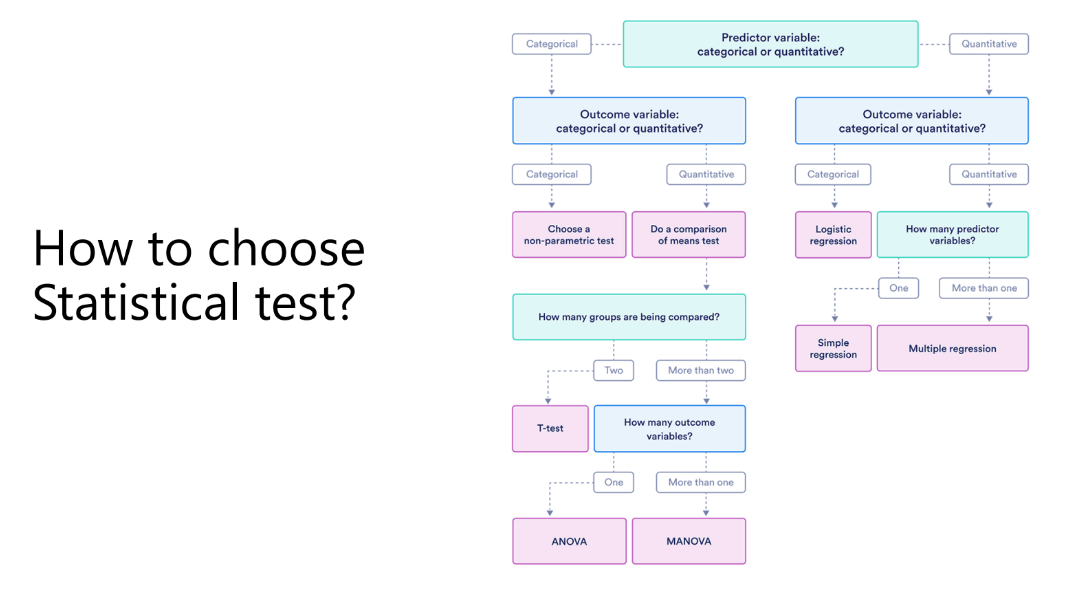

In [4]:
image_path = 'stat_test.png'
width = 800
Image(filename=image_path, width=width)

<center>Main idea to choose MANOVA:</center>

\begin{equation*}
MANOVA = 
\begin{cases}
& 1. \ Predictor \ variable \ (measurement \ method) \ is \ categorical \\
& 2. \ Outcome \ variables \ is \ quantitive \\
& 3. \ Measurement \ method \ has \ more \ than \ two \ groups \\
& 4. \ Outcomes \ variables \ are \ more \ than \ one \\
\end{cases}
\end{equation*}

The MANOVA test will allow us to determine if there are significant differences between the measurements for some of the parameters presented in the dataset. 

In [6]:
df = pd.read_csv('6_clear.csv')
df

normalised_name  raw_value  \
0                                                   C.N   1.000000   
1                          O[P](O)(=O)CNC(=O)OCc1ccccc1   1.000000   
2                                                 O=C=O   1.000277   
3     NC(=N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(O...   1.002600   
4                                              [Cu][I]I   1.004000   
...                                                 ...        ...   
1066                            NCCOB(c1ccccc1)c2ccccc2   4.000000   
1067  OCC1OC(OC2C(O)C(O)C(OC2CO)OC3C(O)C(O)C(OC3CO)O...   4.000000   
1068                                      O[N+]([O-])=O   4.000000   
1069                         [['MgZ', 1.0], ['O', 1.0]]   4.000000   
1070                        [['Mn', 1.0], ['Mn ', 1.0]]   4.000000   

     measurement_method        ABC      ABCGG     nAcid     nBase    SpAbs_A  \
0           el_cde_text   0.000000   0.000000  0.000000  0.000000  28.478428   
1           el_cde_text  11.899854  10.409025  2.000000  0.000000  19.191646   
2         el_cde_tables   1.414214   1.414214  0.000000  0.000000   2.828427   
3           el_cde_text  23.748222  18.952656  1.000000  3.000000  38.424285   
4            el_mylogic   1.414214   1.414214  0.000000  0.000000   2.828427   
...                 ...        ...        ...       ...       ...        ...   
1066        el_cde_text  12.647042  10.934887  0.000000  1.000000  22.445285   
1067      el_cde_tables  34.387982  27.357746  0.000000  0.000000  57.122957   
1068       rsc_cde_text   2.449490   2.449490  0.000000  0.000000   3.464102   
1069      el_cde_tables  11.247571   9.342944  0.488423  0.443219  19.174214   
1070     rsc_cde_tables  11.247571   9.342944  0.488423  0.443219  19.174214   

       SpMax_A  SpDiam_A  ...  HBondAcceptorCount  RotatableBondCount  \
0     2.065207  4.130413  ...            0.000000            2.000000   
1     2.196073  4.392146  ...            5.000000            5.000000   
2     1.414214  2.828427  ...            0.000000            3.000000   
3     2.447029  4.894057  ...            6.000000            9.000000   
4     1.414214  2.828427  ...            0.000000            1.800000   
...        ...       ...  ...                 ...                 ...   
1066  2.334414  4.668828  ...            5.000000           17.000000   
1067  2.487084  4.974167  ...           21.000000           10.000000   
1068  1.732051  3.464102  ...            3.000000            0.000000   
1069  1.961103  3.895626  ...            3.505568            6.562361   
1070  1.961103  3.895626  ...            3.505568            6.562361   

      IsotopeAtomCount  AtomStereoCount  DefinedAtomStereoCount  \
0             0.000000         0.000000                 0.00000   
1             0.000000         0.000000                 0.00000   
2             0.000000         0.000000                 0.00000   
3             0.000000         2.000000                 2.00000   
4             0.000000         0.000000                 0.00000   
...                ...              ...                     ...   
1066          0.000000         0.000000                 0.00000   
1067          0.000000        20.000000                 0.00000   
1068          0.000000         0.000000                 0.00000   
1069          0.181514         1.103563                 0.85078   
1070          0.181514         1.103563                 0.85078   

      UndefinedAtomStereoCount  BondStereoCount  DefinedBondStereoCount  \
0                     0.000000         0.000000                0.000000   
1                     0.000000         0.000000                0.000000   
2                     0.000000         0.000000                0.000000   
3                     0.000000         0.000000                0.000000   
4                     0.000000         0.000000                0.000000   
...                        ...              ...                     ...   
1066                  0.000000 

In [8]:
df_manova = df.drop(['normalised_name'], axis=1)

Let's wright formula, that uses in MANOVA test.

In [10]:
quantitive = list(df_manova.drop(['measurement_method'], axis=1))

# formula represents like 'feature1 + feature2 ~ measurement_method'
formula = ' + '.join(quantitive) + ' ~ measurement_method'
# print(formula)

# below code of clearing formula to use MANOVA (it doesn't make sense, because of 
# this method can evaluate only several descriptors at a time, not at all)

# formula = re.sub(r"\s*\+?\s*AXp\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*Xp\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*BCUT\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*NO\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*PEOE_VSA14_VSA10\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*PEOE_VSA13_VSA1_VSA2_VSA3_VSA4_VSA5_VSA6_VSA7_VSA9\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*GATS2idv\s*", "", formula)
# formula = re.sub(r'\(\)', "", formula)
# formula = re.sub(r"\s*\+?\s*Xc\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*FCSP3h\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*NHOHCountCount\s*", "", formula)
# formula = re.sub(r"\s*\+?\s*SVD\s*", "", formula)

In [11]:
# Create a MANOVA model (we use 73 features, all features can't be calculated)
maov = MANOVA.from_formula(formula = 'NumAliphaticRings + NumAromaticCarbocycles + NumAromaticHeterocycles + NumAromaticRings + NumSaturatedCarbocycles + NumSaturatedHeterocycles + NumSaturatedRings + MolLogP + MolMR + fr_Al_COO + fr_Al_OH + fr_Al_OH_noTert + fr_ArN + fr_Ar_COO + fr_Ar_N + fr_Ar_OH + fr_COO + fr_COO2 + fr_C_O + fr_C_O_noCOO + fr_Imine + fr_NH0 + fr_NH1 + fr_NH2 + fr_Ndealkylation1 + fr_Ndealkylation2 + fr_aldehyde + fr_alkyl_halide + fr_allylic_oxid + fr_amide + fr_aniline + fr_aryl_methyl + fr_benzene + fr_bicyclic + fr_epoxide + fr_ester + fr_ether + fr_guanido + fr_imidazole + fr_ketone + fr_ketone_Topliss + fr_lactone + fr_methoxy + fr_nitrile + fr_nitro + fr_nitro_arom + fr_para_hydroxylation + fr_phenol + fr_phenol_noOrthoHbond + fr_phos_acid + fr_phos_ester + fr_piperdine + fr_priamide + fr_pyridine + fr_quatN + fr_sulfide + fr_unbrch_alkane + XLogP + ExactMass + MonoisotopicMass + Complexity + Charge + HBondDonorCount + HBondAcceptorCount + RotatableBondCount + IsotopeAtomCount + AtomStereoCount + DefinedAtomStereoCount + UndefinedAtomStereoCount + BondStereoCount + DefinedBondStereoCount + UndefinedBondStereoCount + CovalentUnitCount ~ measurement_method',
                           data = df_manova)
# Print the results
print(maov.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
         Intercept        Value   Num DF  Den DF  F Value Pr > F
----------------------------------------------------------------
            Wilks' lambda 0.4336 70.0000 993.0000 18.5339 0.0000
           Pillai's trace 0.6877 70.0000 993.0000 31.2319 0.0000
   Hotelling-Lawley trace 1.2704 70.0000 993.0000 18.0219 0.0000
      Roy's greatest root 1.5133 70.0000 993.0000 21.4669 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
   measurement_method   Value   Num DF    Den DF  F Value Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.4870 560.0000 7915.7593  1.3387 0.0000
         Pillai's trace 0.6764 560.0000 8000.

The output shows the analysis using different test statistics.

There is no absolute consensus in the statistical literature as to which test statistic should be preferred.

=======================================================================================================================

(+) The Wilks' lambda value of 0.4870 indicates that the groups of observations in the MANOVA test are fairly well separated by dependent variables. Values between 0 and 1 indicate the degree of group separation, where 0 means perfect group separation.

(+) Pillai's trace value of 0.6764 in the MANOVA test suggests that there is a statistically significant difference between groups in the dependent variables. The closer the Pillai's trace value is to 1, the greater the differences between groups in the dependent variables, and values close to 0 indicate that the differences between groups are not significant.

(+) The larger the Hotelling-Lawley trace value, the more significant the differences between the groups.

(+) The more Roy's greatest root in the MANOVA test, the better the separation of the groups.

The p-values are shown in the right column and are all less than 0.05, which confirms that chemical compounds (more specifically, their properties) have an impact on measurement_method.

=======================================================================================================================

The first table shows how the means of dependent variables differ between groups (between-subjects variability). 

The second table shows how the values of dependent variables change within each group (within-subjects variability).

Let's visualise via boxplots. 

In [14]:
df_box = df[['measurement_method', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_aldehyde', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_aniline', 'fr_aryl_methyl', 'fr_benzene', 'fr_bicyclic', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_guanido', 'fr_imidazole', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactone', 'fr_methoxy', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_priamide', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_unbrch_alkane', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount', 'UndefinedBondStereoCount', 'CovalentUnitCount']]
df_box

measurement_method  NumAliphaticRings  NumAromaticCarbocycles  \
0           el_cde_text           0.000000                0.000000   
1           el_cde_text           0.000000                1.000000   
2         el_cde_tables           0.000000                0.000000   
3           el_cde_text           2.000000                1.000000   
4            el_mylogic           0.000000                0.000000   
...                 ...                ...                     ...   
1066        el_cde_text           0.000000                2.000000   
1067      el_cde_tables           4.000000                0.000000   
1068       rsc_cde_text           0.000000                0.000000   
1069      el_cde_tables           0.457552                0.549063   
1070     rsc_cde_tables           0.457552                0.549063   

      NumAromaticHeterocycles  NumAromaticRings  NumSaturatedCarbocycles  \
0                     0.00000          0.000000                 0.000000   
1                     0.00000          1.000000                 0.000000   
2                     0.00000          0.000000                 0.000000   
3                     0.00000          1.000000                 1.000000   
4                     0.00000          0.000000                 0.000000   
...                       ...               ...                      ...   
1066                  0.00000          2.000000                 0.000000   
1067                  0.00000          0.000000                 0.000000   
1068                  0.00000          0.000000                 0.000000   
1069                  0.23043          0.779493                 0.071665   
1070                  0.23043          0.779493                 0.071665   

      NumSaturatedHeterocycles  NumSaturatedRings   MolLogP      MolMR  ...  \
0                     0.000000           0.000000  0.798100   11.75310  ...   
1                     0.000000           0.000000  1.048000   56.67380  ...   
2                     0.000000           0.000000 -0.583500    5.00700  ...   
3                     1.000000           2.000000  0.810870  115.42430  ...   
4                     0.000000           0.000000  1.768900   28.04000  ...   
...                        ...                ...       ...        ...  ...   
1066                  0.000000           0.000000  0.767600   72.91240  ...   
1067                  4.000000           4.000000 -9.748800  133.88620  ...   
1068                  0.000000           0.000000 -0.347700    8.78090  ...   
1069                  0.261301           0.332966  0.496722   58.14388  ...   
1070                  0.261301           0.332966  0.496722   58.14388  ...   

      HBondAcceptorCount  RotatableBondCount  IsotopeAtomCount  \
0               0.000000            2.000000          0.000000   
1               5.000000            5.000000          0.000000   
2               0.000000            3.000000          0.000000   
3               6.000000            9.000000          0.000000   
4               0.000000            1.800000          0.000000   
...                  ...                 ...               ...   
1066            5.000000           17.000000          0.000000   
1067           21.000000           10.000000          0.000000   
1068            3.000000            0.000000          0.000000   
1069            3.505568            6.562361          0.181514   
1070            3.505568            6.562361          0.181514   

      AtomStereoCount  DefinedAtomStereoCount  UndefinedAtomStereoCount  \
0            0.000000                 0.00000                  0.000000   
1            0.000000                 0.00000                  0.000000   
2            0.000000                 0.00000                  0.000000   
3            2.000000                 2.00000                  0.000000   
4            0.000000                 0.00000                  0.000000   
...               ...                     ...              

In [15]:
# print unique methods
unique_methods = df_box['measurement_method'].unique()
print(unique_methods)

['el_cde_text' 'el_cde_tables' 'el_mylogic' 'springer_cde_table'
 'rsc_cde_tables' 'rsc_mylogic' 'rsc_cde_text' 'snowball'
 'springer_cde_text']


In [16]:
# print(name of columns)
column_list = df_box.drop(['measurement_method'], axis=1).columns.tolist()
print(column_list)

['NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'MolLogP', 'MolMR', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_aldehyde', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_aniline', 'fr_aryl_methyl', 'fr_benzene', 'fr_bicyclic', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_guanido', 'fr_imidazole', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactone', 'fr_methoxy', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_priamide', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_unbrch_alkane', 'XLogP', 'ExactMass', 'MonoisotopicMass', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorC

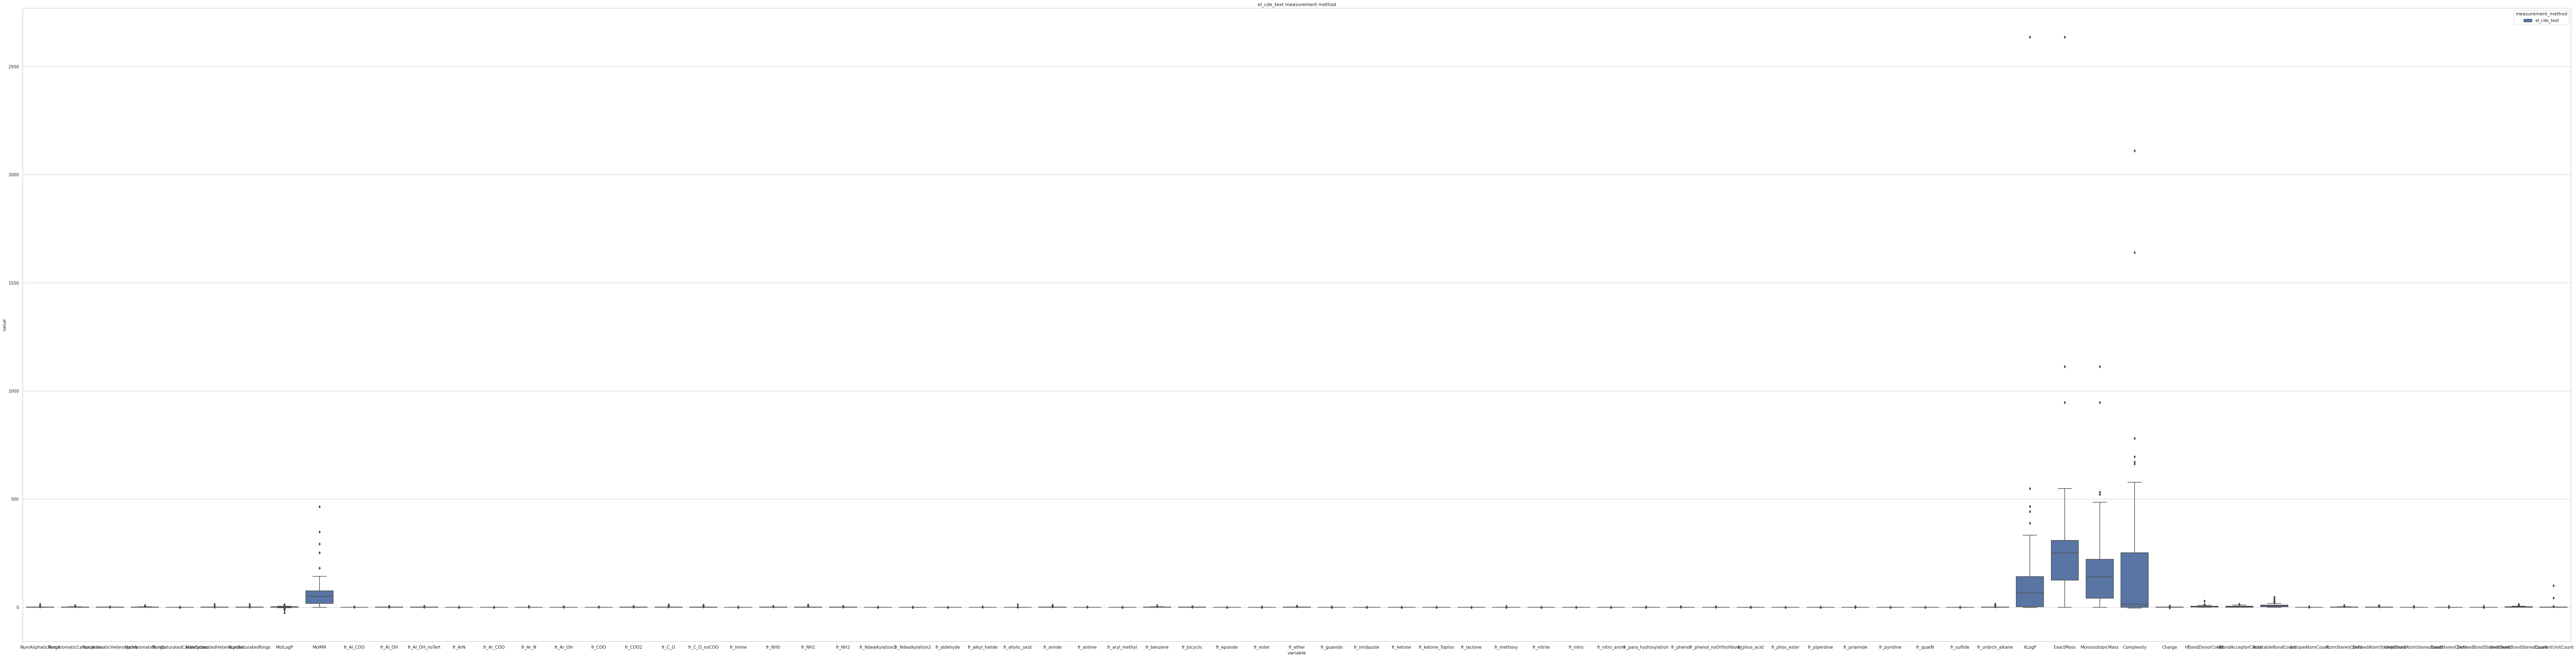

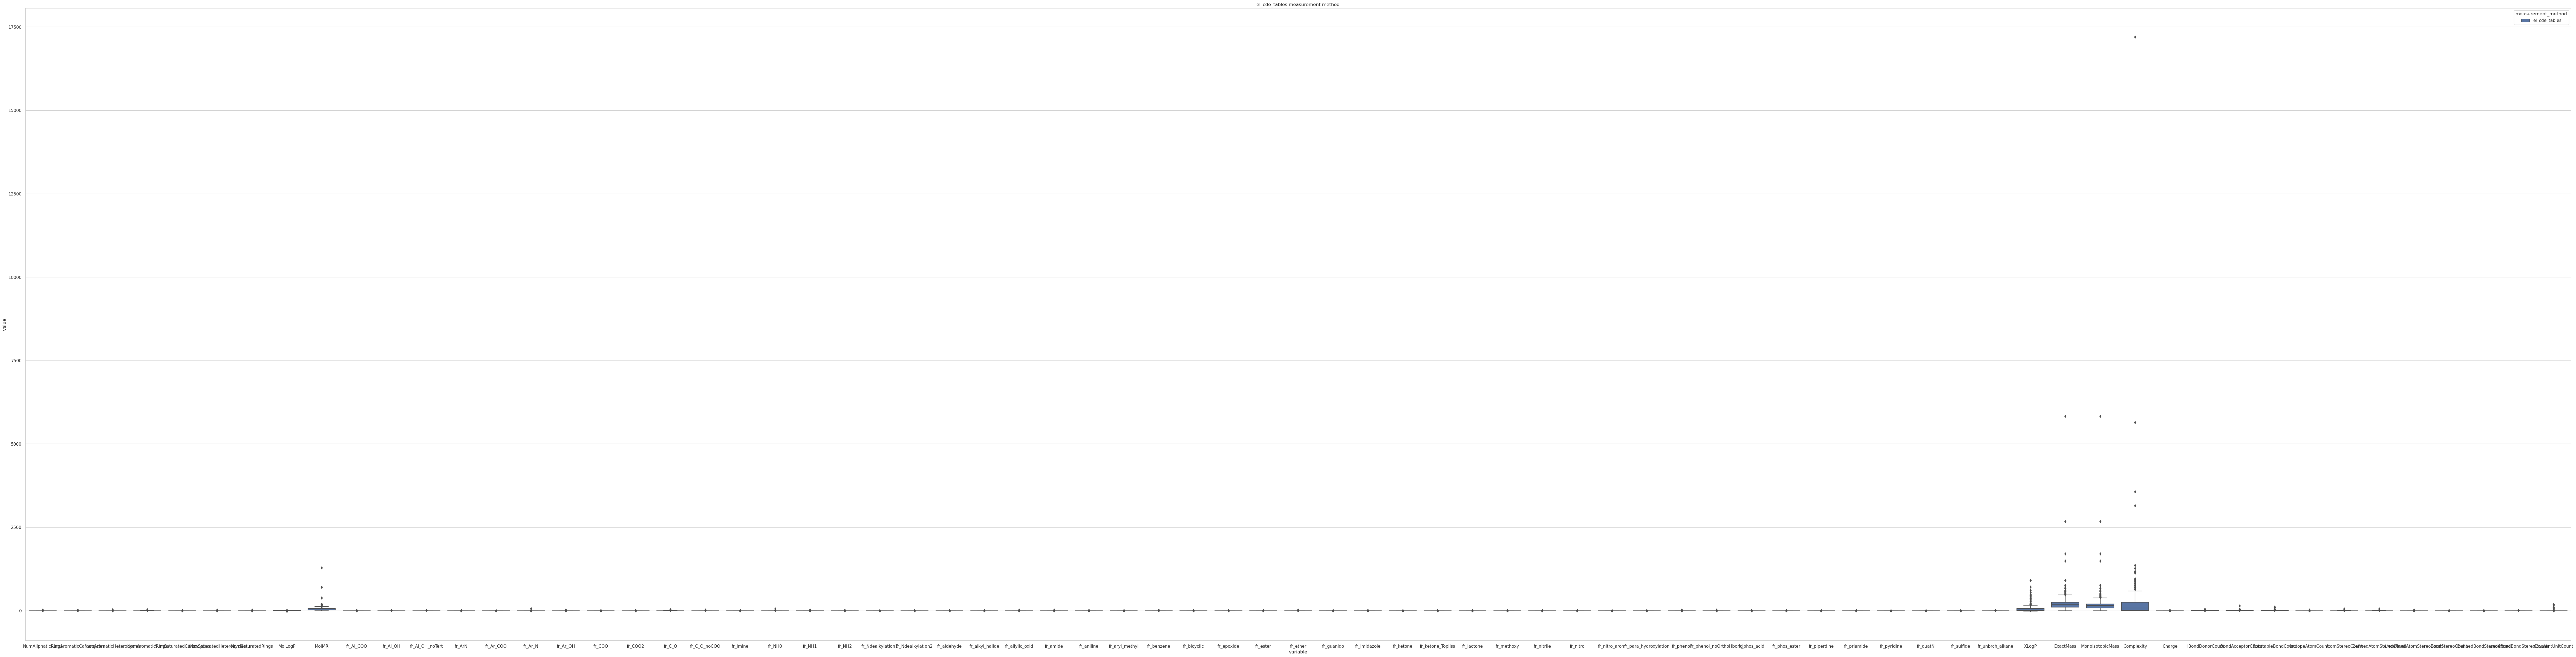

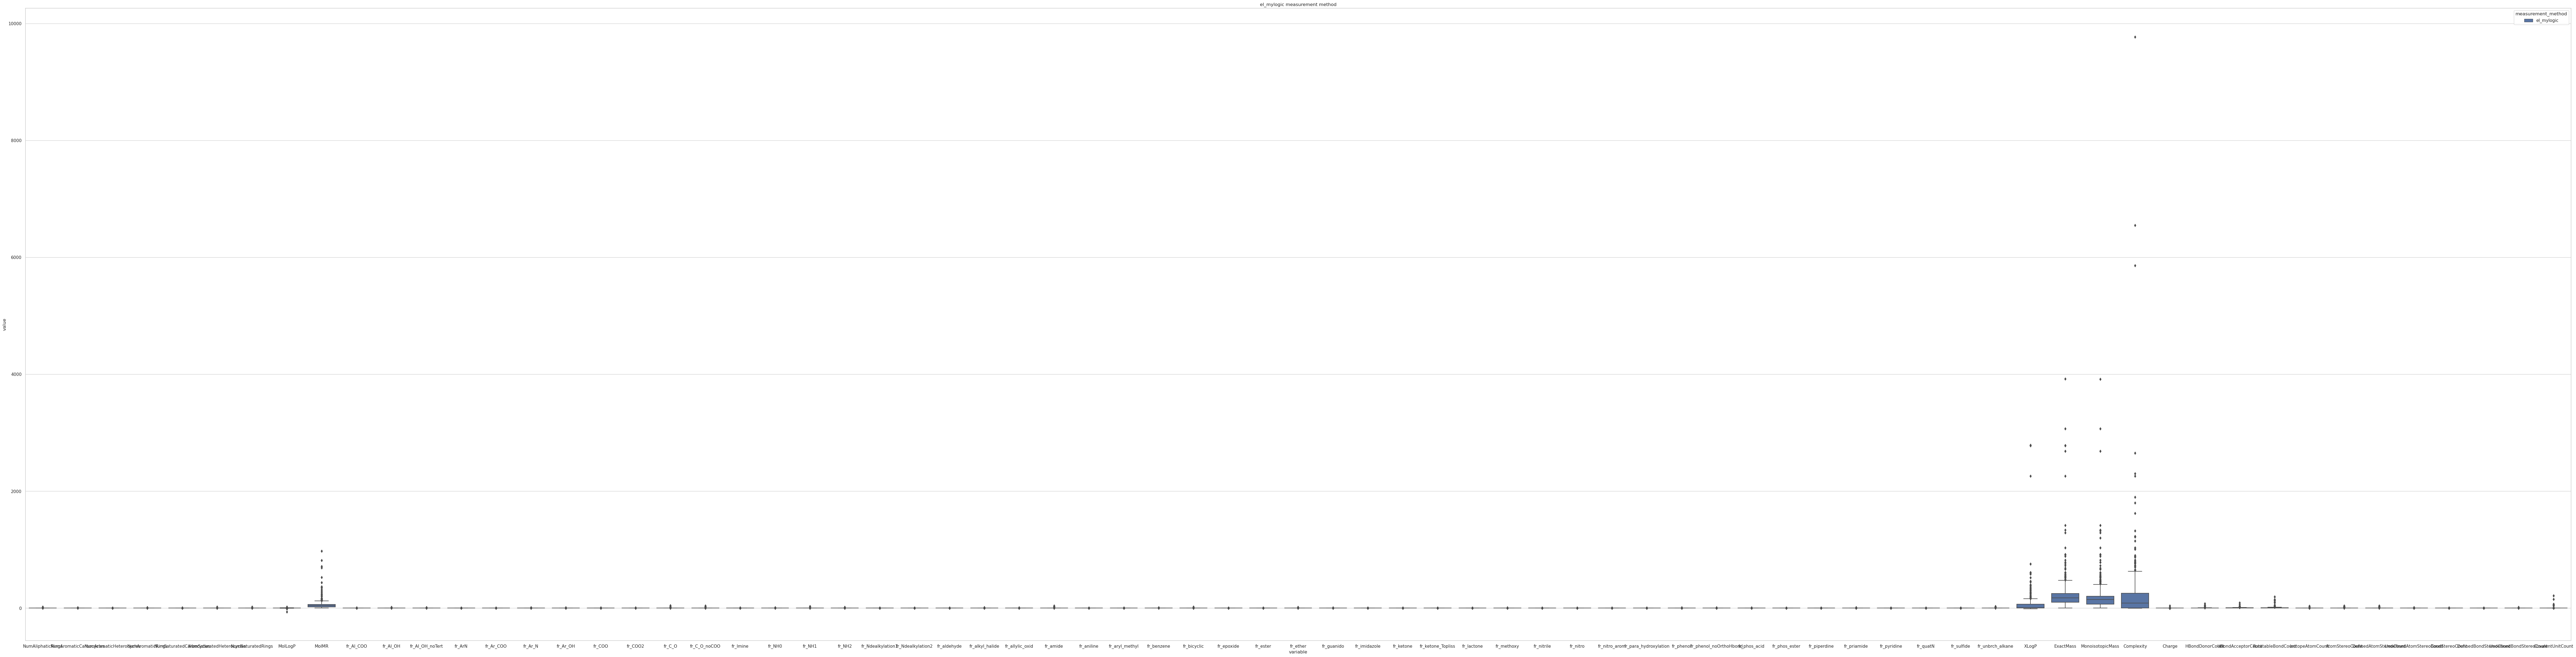

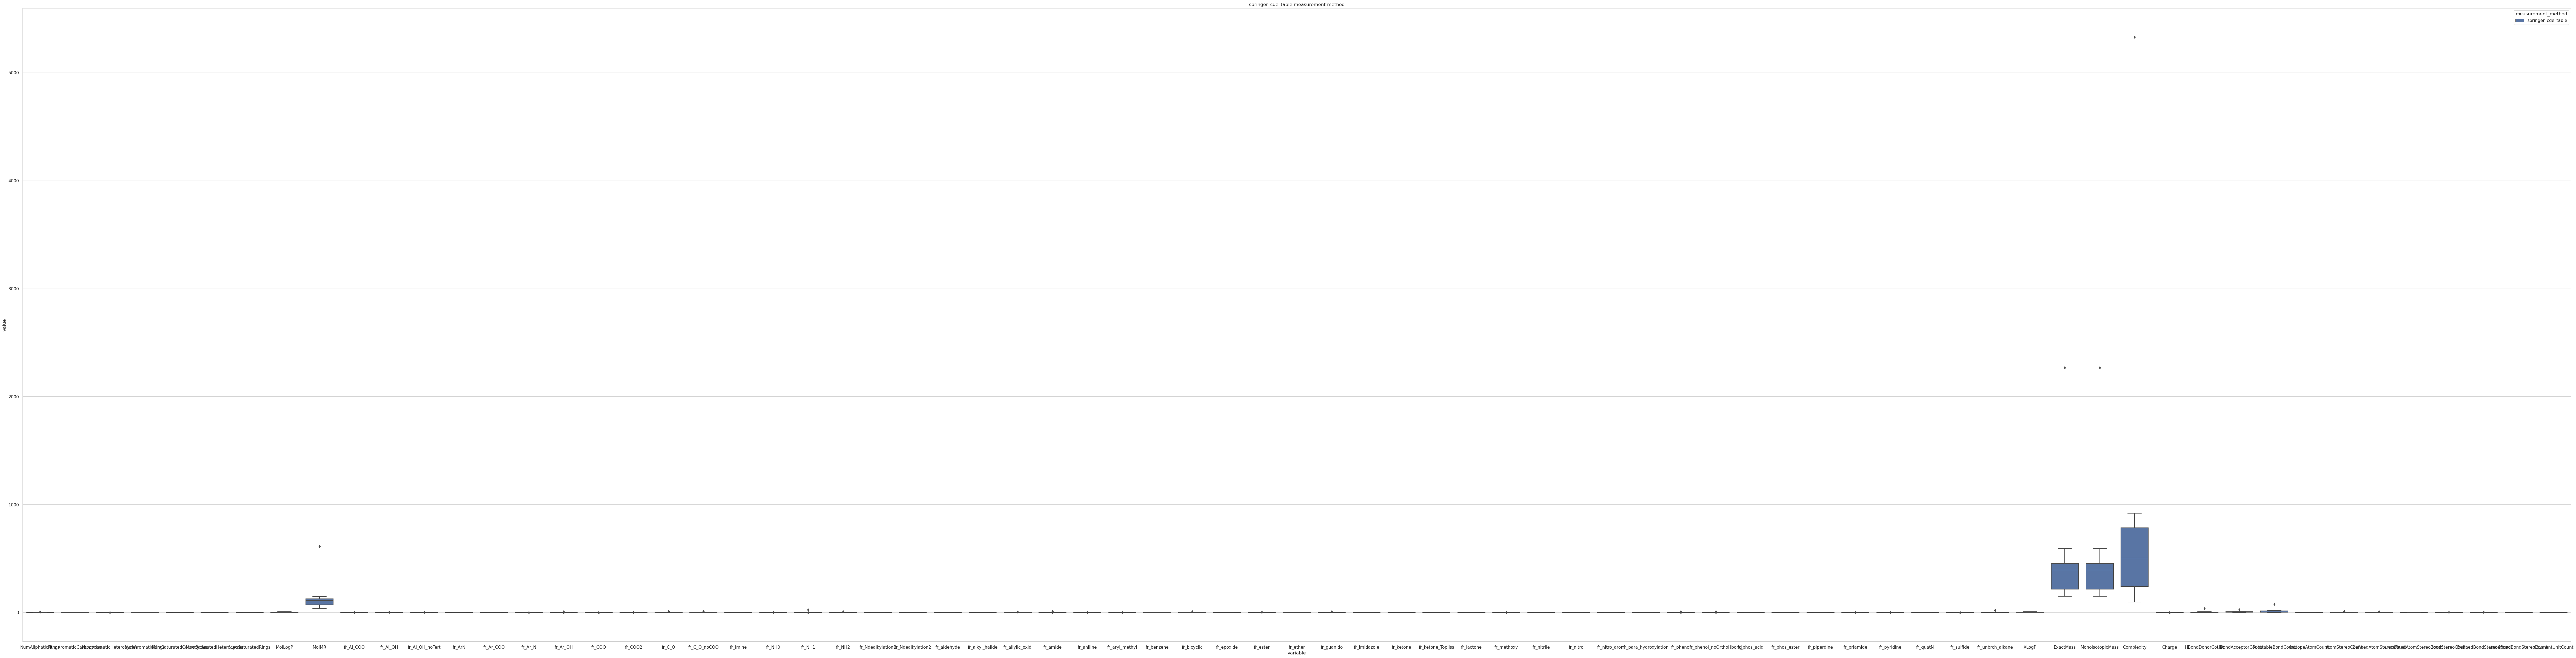

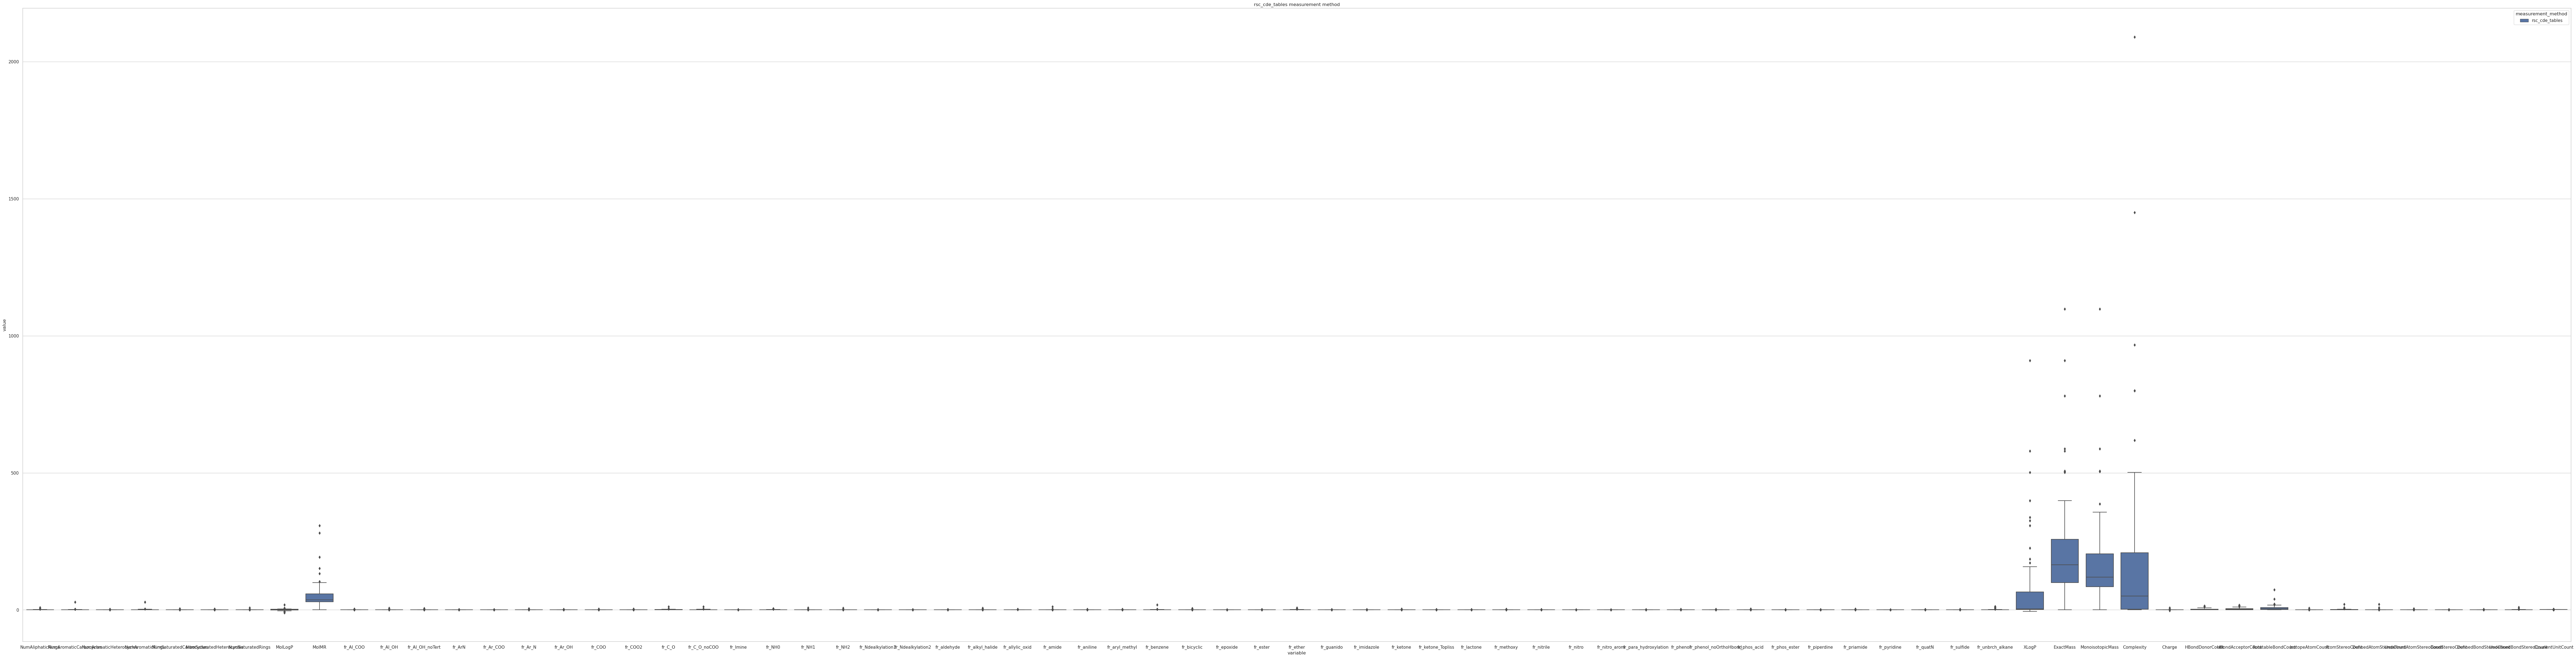

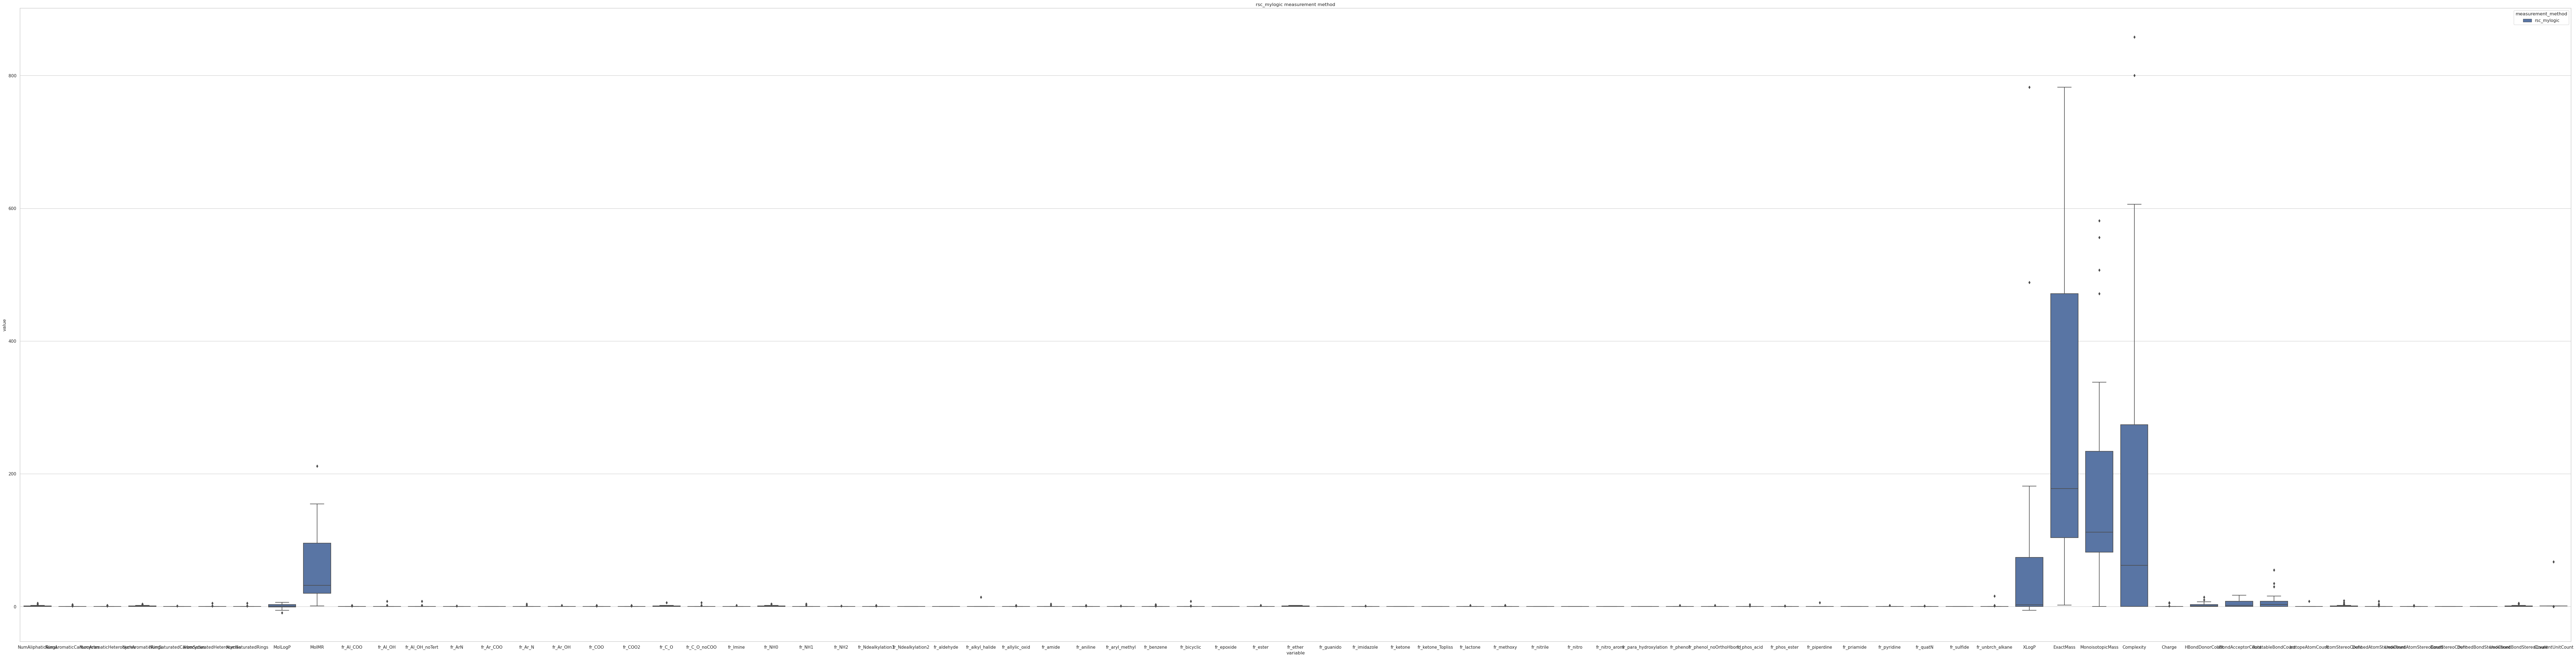

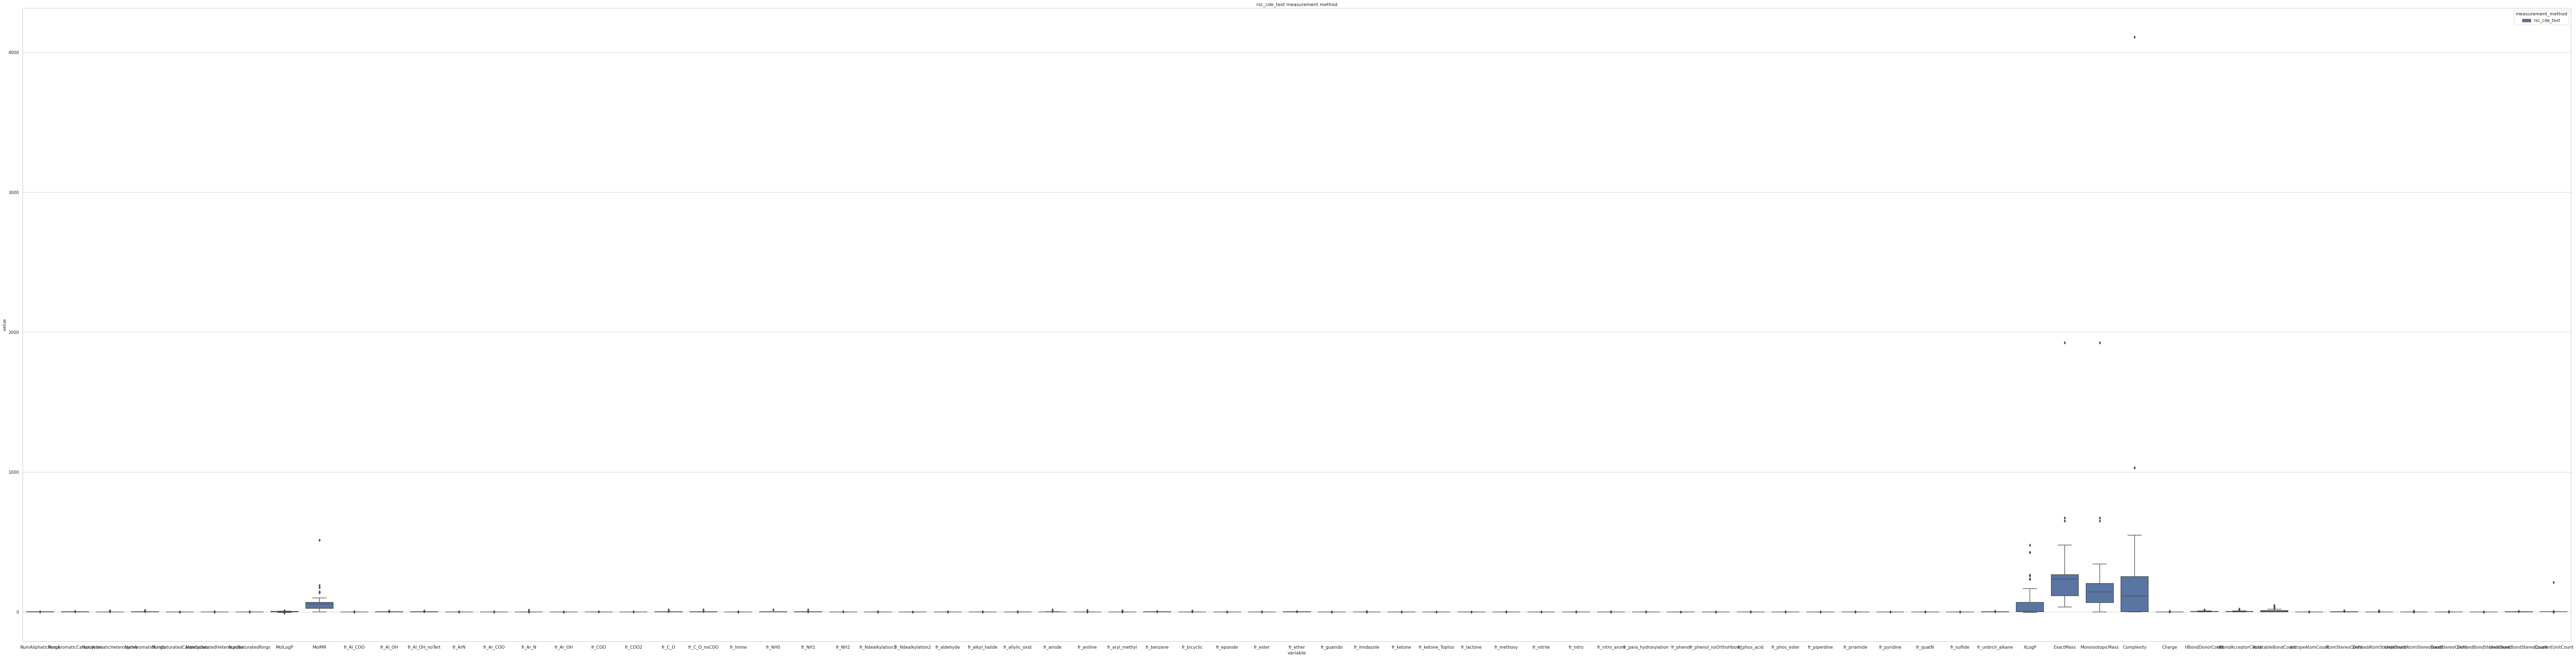

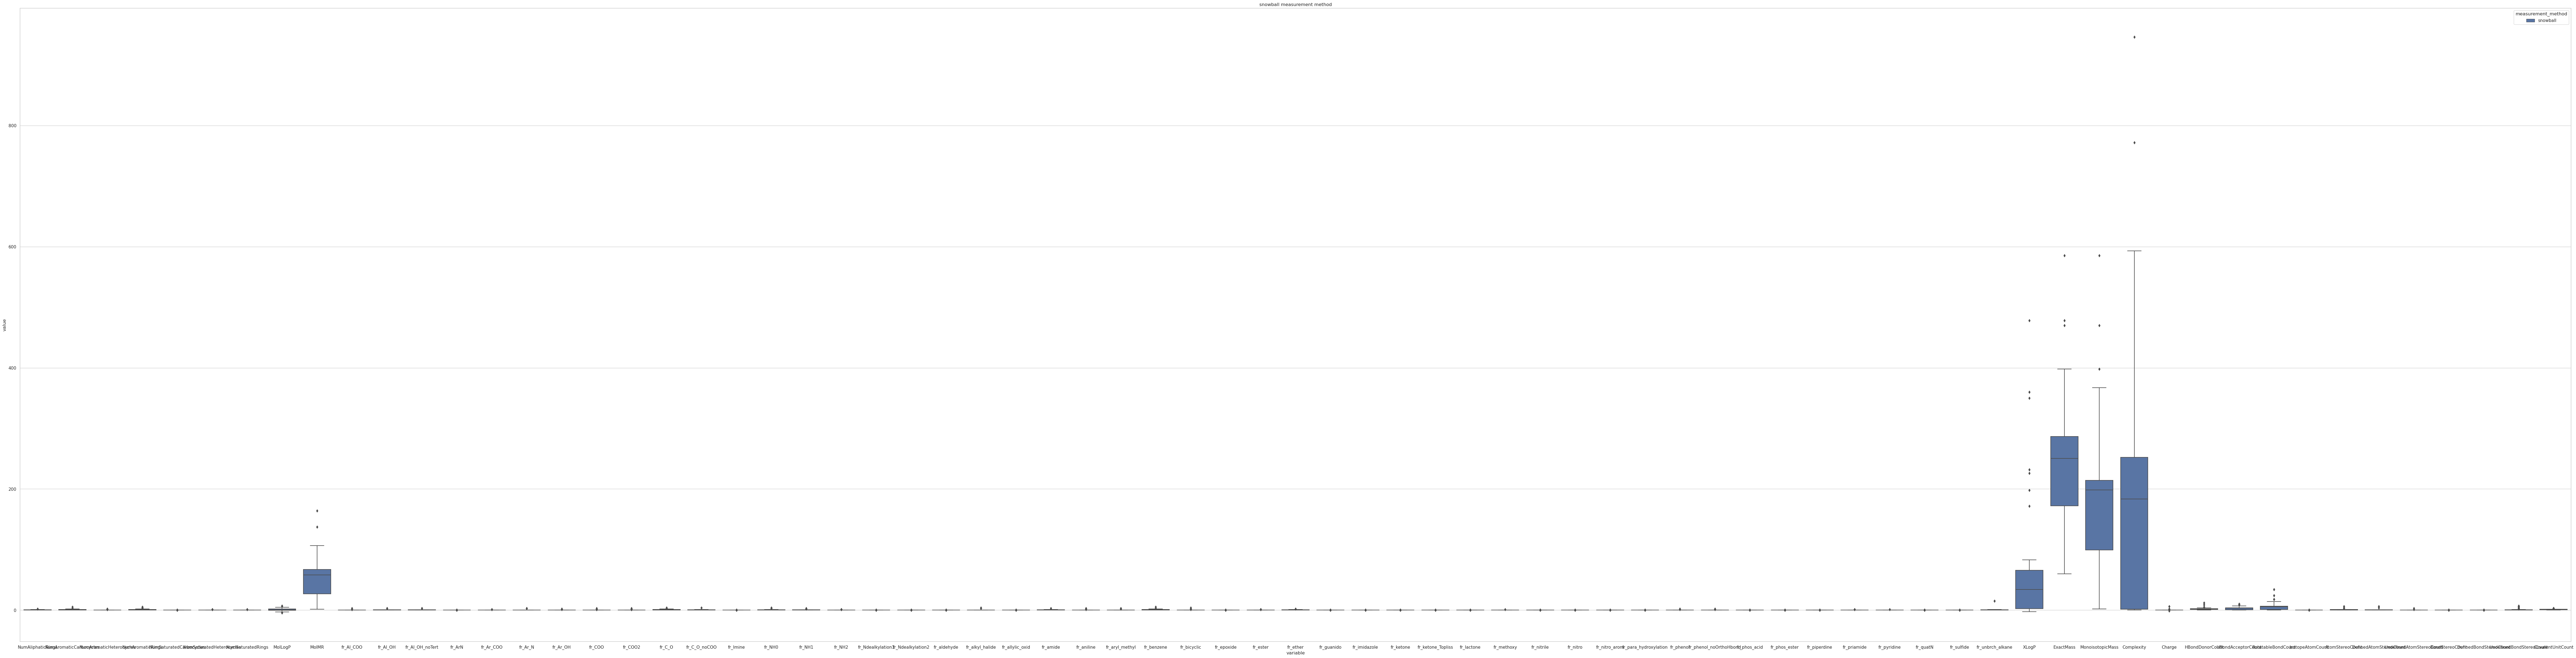

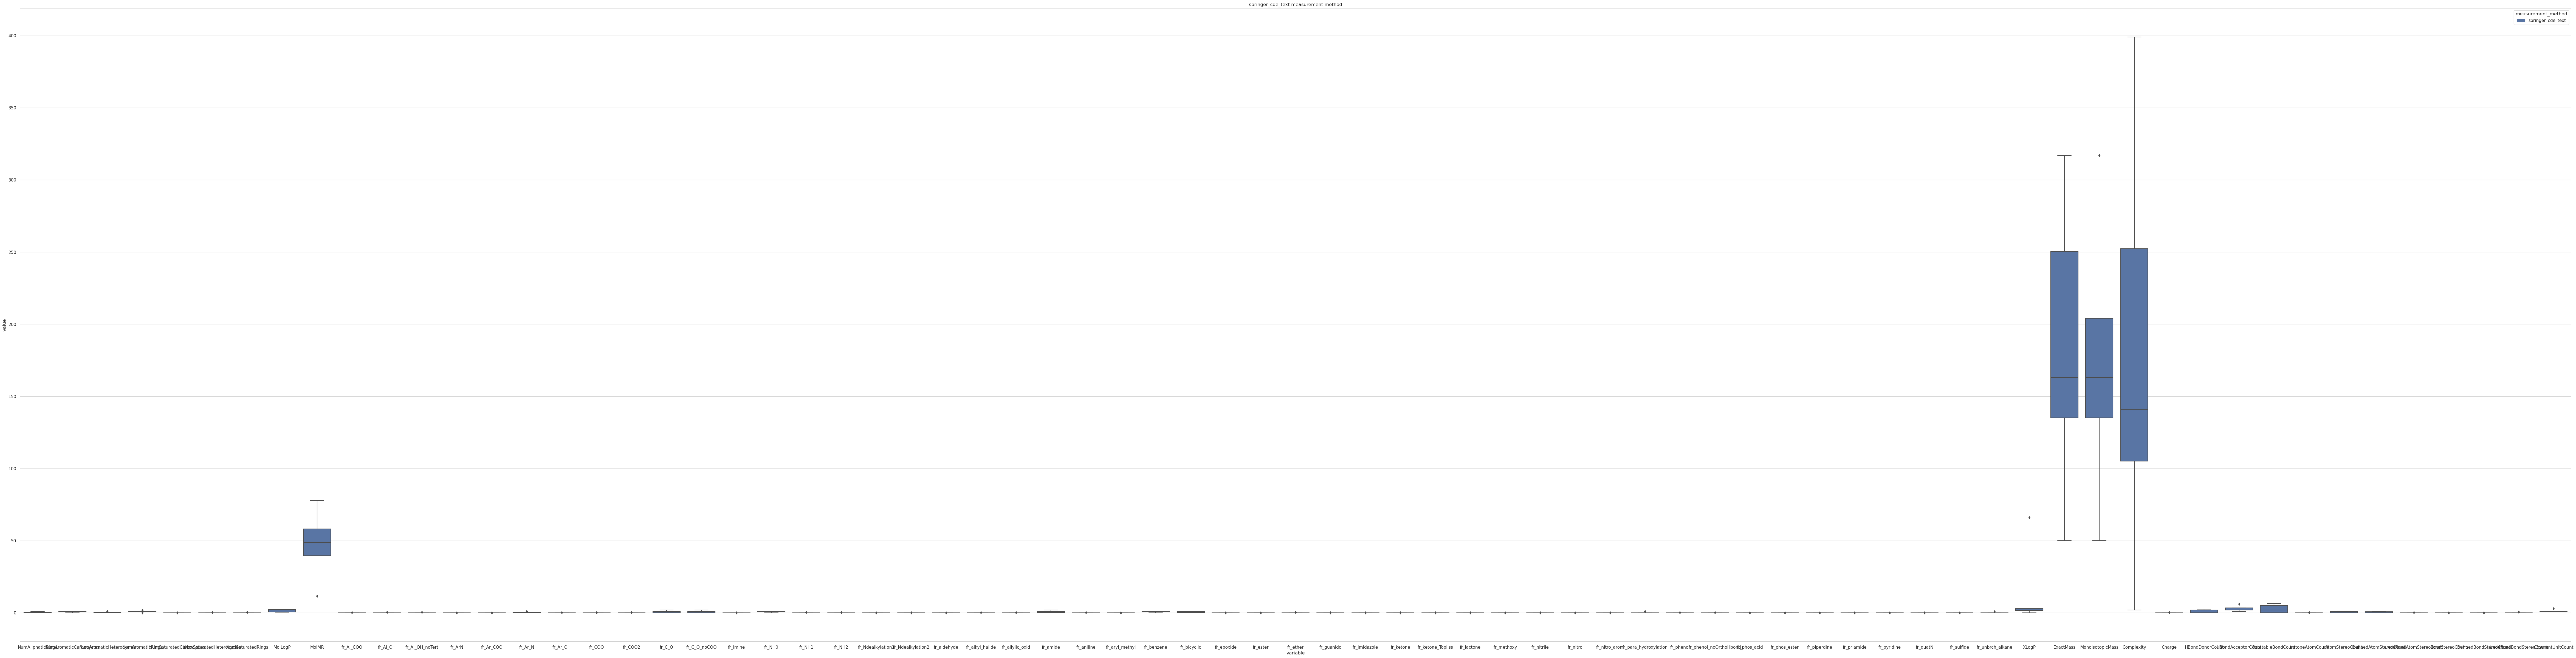

In [17]:
# use data for only one measurement method
for method in unique_methods:
    df_method = df_box[df_box['measurement_method'] == f'{method}']

#   melt the filtered dataframe to create a new melted dataframe for the boxplot
    melted_data = pd.melt(df_method, id_vars=['measurement_method'], value_vars=column_list)
    plt.figure(figsize=(120, 30))
    
#   use seaborn plot and specify the x and y columns and the melted dataframe, with hue as the variable to plot
    sns.boxplot(x='variable', y='value', data=melted_data, hue='measurement_method')

#   set the plot title
    plt.title(f'{method} measurement method')

#   show the plot
    plt.show()

To enlarge an image, you can double-click on it.

As we can see, indeed the methods of measuring the refractive index depend on some parameters of these chemicals.

### Linear correlation

Let's set a function that removes parameters that have a correlation greater than the specified trashold

In [15]:
df_norm = pd.read_csv('df/6_clear_normalised.csv')

In [16]:
def remove_corr(df_corr, df, crop_value):
    
    # restrict the upper triangle in order to later select the features 
    upper_tri = df_corr.where(np.triu(np.ones(df_corr.shape), k=1) != 0)

    # select the parameters that need to be removed
    to_drop = [column for column in upper_tri.columns if any((upper_tri[column] > crop_value))]
    print('Number of strongly correlated parameters:', len(to_drop))

    # get a dataframe of weakly and moderately correlated features
    df_small = df.drop(to_drop, axis=1)

    return df_small

To start with Pearson correlation coefficients between all parameters and visualize this with heatmap. These coefficients illustrate the linear correlation of the two values

In [17]:
# calculate the coefficients by absolute value
df_corr = df_norm.iloc[:, 1:].corr(method='pearson').abs()

<Axes: >

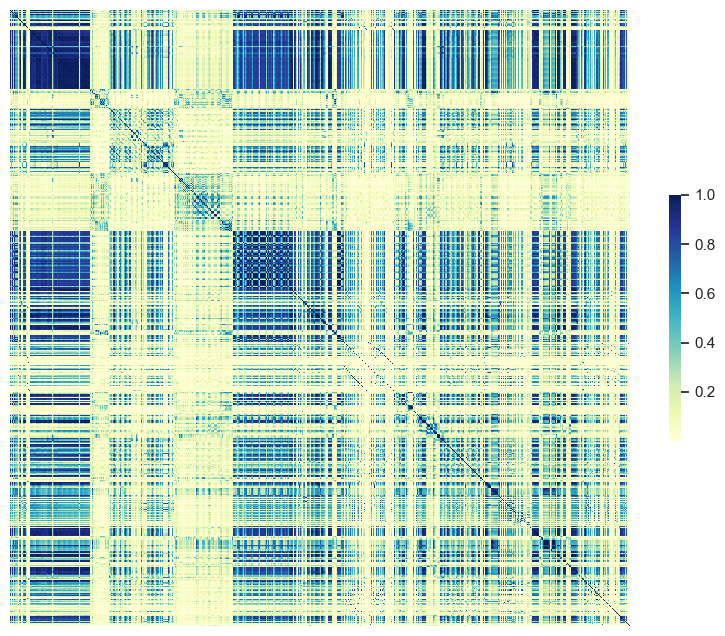

In [18]:
# build a heat map
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_corr, cmap="YlGnBu", yticklabels=False, xticklabels=False, ax=ax, cbar_kws={"shrink": 0.4})

Of course, in practical problems, thermal diagrams are rarely applied to high-dimensional data, because they have low informativeness. However, as we can see, some of the parameters have a low correlation between each other. Let's try to remove the features whose correlation is strong and exceeds the value of 0.6. 

In [19]:
# apply a function that removes strongly correlated parameters
df_small = remove_corr(df_corr, df_norm.iloc[:, 1:], 0.6)

Number of strongly correlated parameters: 910


In [20]:
# calculate the coefficients by absolute value
df_small_corr = df_small.corr(method='pearson').abs()

<Axes: >

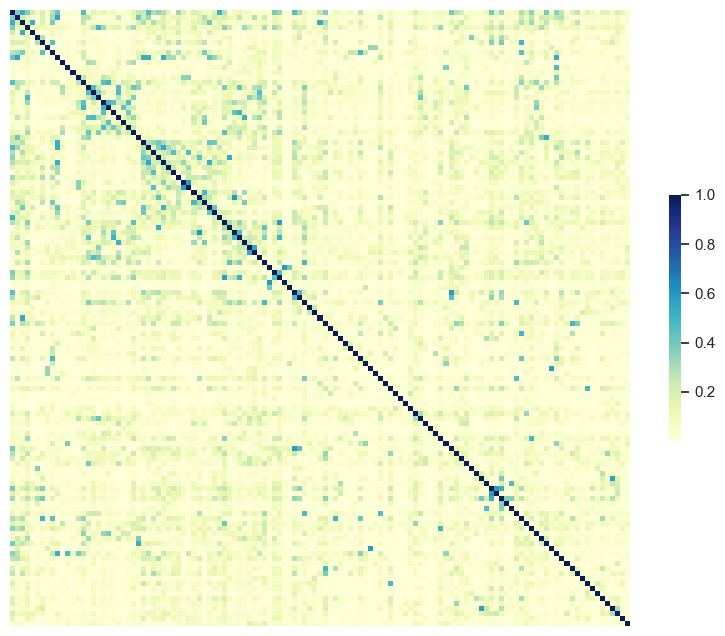

In [21]:
# build a heat map
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_small_corr, cmap="YlGnBu", xticklabels=False, yticklabels=False, ax=ax, cbar_kws={"shrink": 0.4})

At this point, the heatmap looks much clearer, however, the number of features is still large to display descriptor names. However, we can recognize the number of them.

In [22]:
# calculate the number of parameters after removing the strong correlations
print('Number of remaining parameters:', len(df_small.columns))

Number of remaining parameters: 123


### Non-linear correlation

Also, after removing the linear Pearson correlations, we can check for non-linear correlations by calculating Spearman correlation coefficients.

In [23]:
# calculate the coefficients by absolute value
df_corr = df_small.corr(method='spearman').abs()

<Axes: >

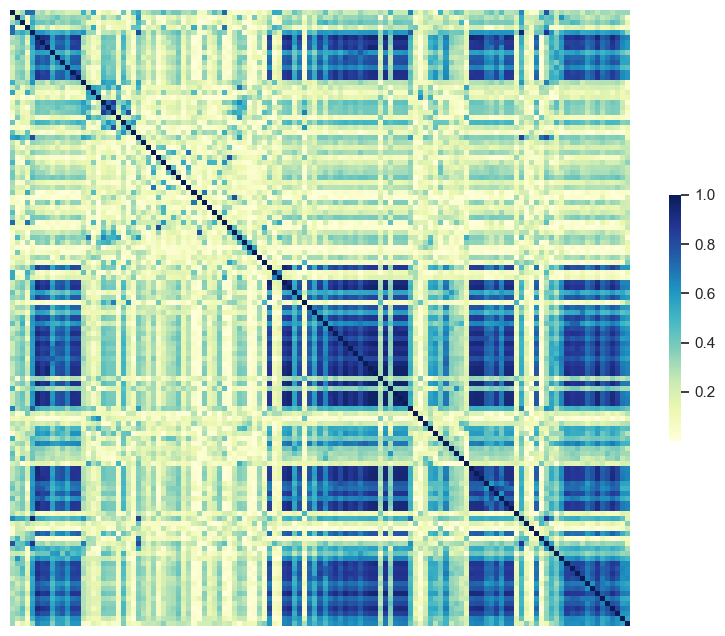

In [24]:
# build a heat map
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_corr, cmap="YlGnBu", xticklabels=False, yticklabels=False, ax=ax, cbar_kws={"shrink": 0.4})

We can see that about half of the parameters have a strong correlation with each other, remove these features.

In [25]:
# apply a function that removes strongly correlated parameters
df_small_nonlin = remove_corr(df_corr, df_small, 0.6)

Number of strongly correlated parameters: 81


In [26]:
# calculate the coefficients by absolute value
df_small_nonlin_corr = df_small_nonlin.corr(method='spearman').abs()

<Axes: >

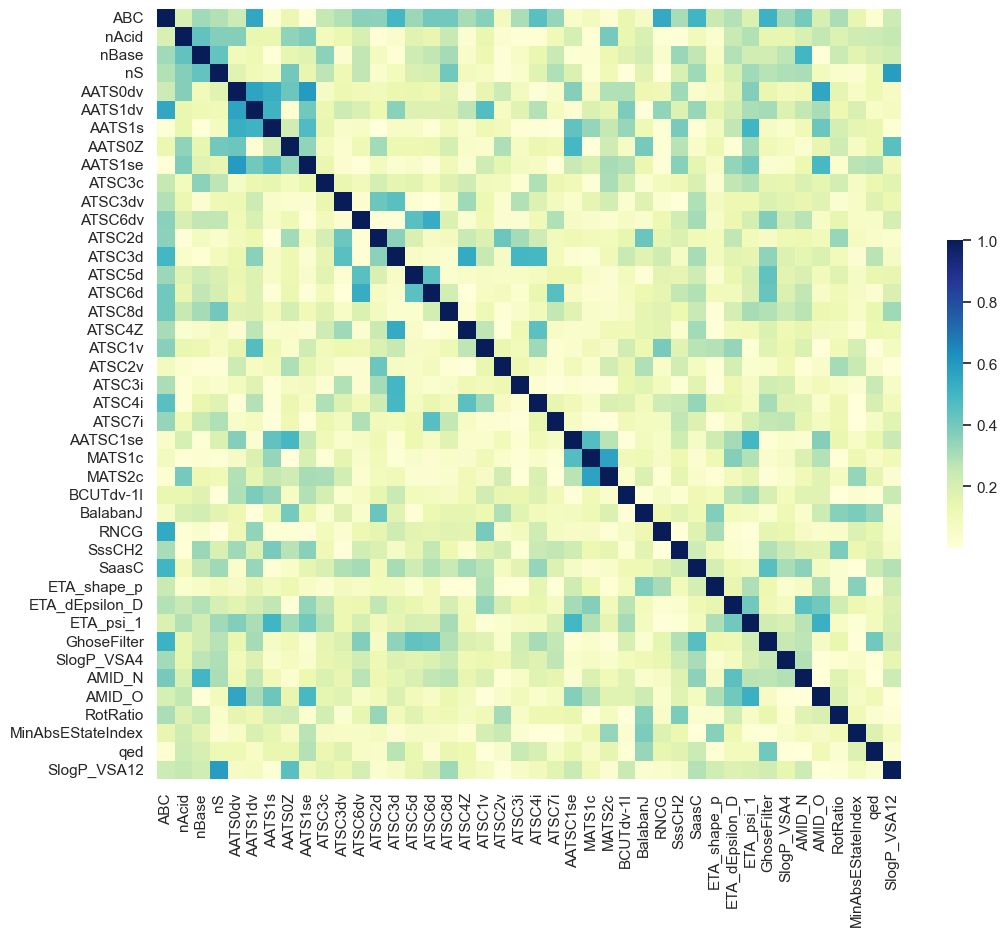

In [30]:
# build a heat map
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_small_nonlin_corr, cmap="YlGnBu", ax=ax, cbar_kws={"shrink": 0.4})

Now we have a dataset of 42 parameters, which has low to moderate correlations. Now the number of features is suitable for building a nice looking heat map.

In [28]:
# calculate the number of parameters after removing the strong correlations
print('Number of remaining parameters:', len(df_small_nonlin.columns))

Number of remaining parameters: 42


### Linear methods of dimensionality reduction

In the lecture we were introduced to three methods of linear dimensionality reduction, among them principal component analysis (which cannot be used in the assignment), linear discriminant analysis, and independent component analysis. LDA is designed to solve classification problems, so it is not suitable for us. In ICA, the hypothesis that the components have a non-normal distribution and their sources are independent is accepted, as originally this method was used for the analysis of audio signals. This method is quite good, but it has low interpretation, which complicates the choice of the number of required components.

Therefore it was decided to use singular value decomposition (SVD) as a linear dimensionality reduction method. When selecting the number of components in SVD (as well as in PCA) we focus exactly on the cumulative variance, which the considered components give.

In [31]:
# divide the data
X_norm = df_norm.drop(columns=['raw_value'], axis = 1)
Y = df_norm['raw_value']

In [32]:
# perform SVD with 100 components
svd = TruncatedSVD(n_components = 100)
X_svd = svd.fit_transform(X_norm)

In [33]:
# calculate cumulative variance
y = np.cumsum(svd.explained_variance_ratio_)

In [34]:
# calculate principal components
xi = np.arange(1, y.shape[0]+1, step=1)

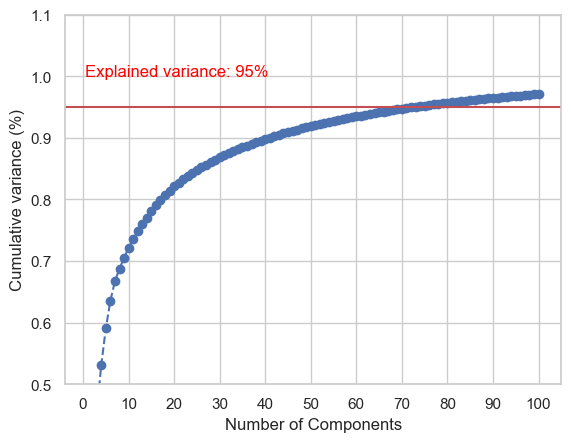

In [35]:
# plot results
plt.ylim(0.5,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 101, step=10))
plt.ylabel('Cumulative variance (%)')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 1, 'Explained variance: 95%', color = 'red', fontsize=12)
plt.show()

As we can see, 75 components is sufficient, since this is when the cumulative variance reaches 0.95.

In [36]:
# perform SVD with 75 components
svd = TruncatedSVD(n_components = 75)
X_svd = svd.fit_transform(X_norm)

In [37]:
# translate to dataframe
df_pc = pd.DataFrame(data = X_svd, columns = [f'SV{i}' for i in range(1,76)])

Let us try to partially explain the physical meaning of some obtained singular vectors by checking the correlation with the available features.

In [38]:
# combine the original data (X_pubchem) and first three PCs
df_col = pd.concat([df_pc[['SV10','SV20','SV30']], pd.DataFrame(X_norm.iloc[:,:10], columns=X_norm.iloc[:,:10].columns)], axis=1)

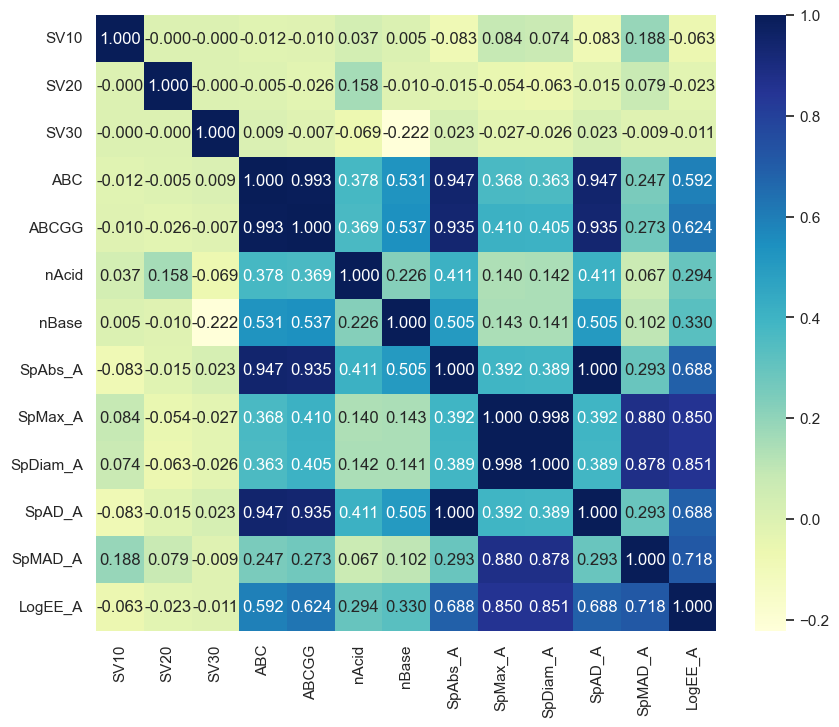

<Figure size 2800x1800 with 0 Axes>

In [44]:
# compute the correlations between the original data and SVs
corMatrix = pd.DataFrame.corr(df_col)

# plot the results
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(corMatrix, annot=True, fmt='.3f', cmap="YlGnBu")
plt.figure(figsize=(28,18))
plt.show()

We may notice here that:
1. SV10 shows the highest value of correlation with parameter SpMAD_A
2. SV20 shows correlation with the number of acid groups
3. SV30, on the contrary, is oriented to the number of base groups. 

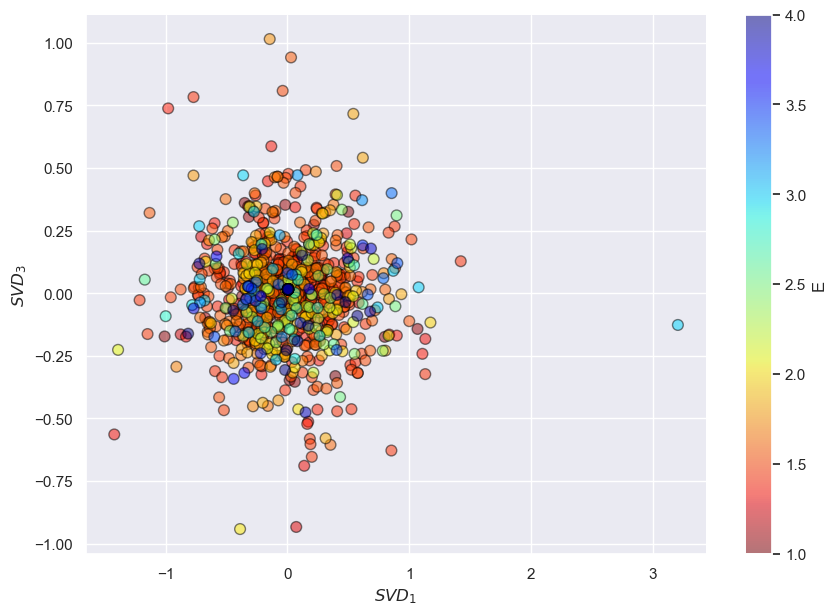

In [40]:
# plot results
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(111)
scatter = ax.scatter(X_svd[:, 10], X_svd[:, 30], c = Y, s=60, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
colorbar = fig.colorbar(scatter, ax=ax, label = "E")
plt.xlabel(r'$SVD_1$')
plt.ylabel(r'$SVD_3$')
sns.despine()
plt.show()

As one might assume, samples are not clustered in this case, but such clustering may be possible in one of the SV combinations.

### Non-linear methods of dimensionality reduction

Among the nonlinear dimensionality reduction methods, the most suitable are T-distributed Stochastic Neighbor Embedding and Uniform Manifold Approximation and Projection, since they are designed for high dimensional data.

t-SNE is also robust to data noise, which is a definite plus. This method contains a perplexity variable. Let's try to observe the change in plots when perplexity changes.

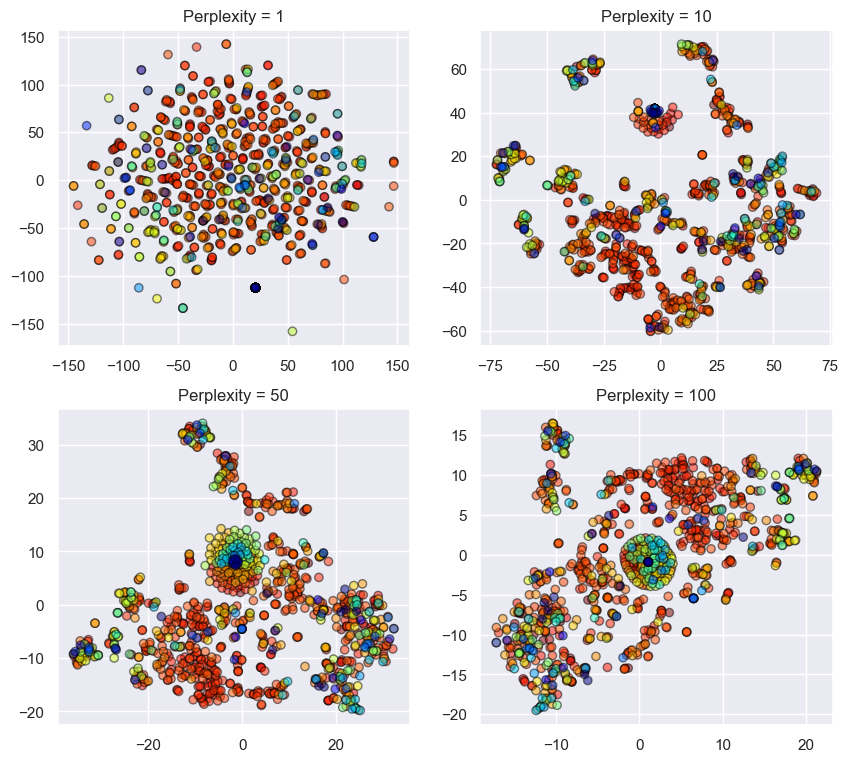

In [41]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, p in enumerate([1, 10, 50, 100]):

    # perform t-SNE
    tsne = TSNE(n_components = 2, perplexity = p, random_state=0)
    tsne_results = tsne.fit_transform(X_norm)
    
    tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
    
    # plot the results
    plt.subplot(2,2,index+1)
    plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=Y, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
    plt.title('Perplexity = '+ str(p))

plt.show()

As we can see, as perplexity increases, the samples accumulate strongly in the center of the plot. This is probably what is called the "crowding problem" in this method, which should be solved by using the student t distribution in the SNE method. But there could probably be other reasons for this.

But still, at a perplexity value of 10 we can observe a good clustering of data.

But let's also try the UMAP method. Since it is quite sensitive to the choice of hyperparameters, let's try different variants of min_dist and n_neighbors.

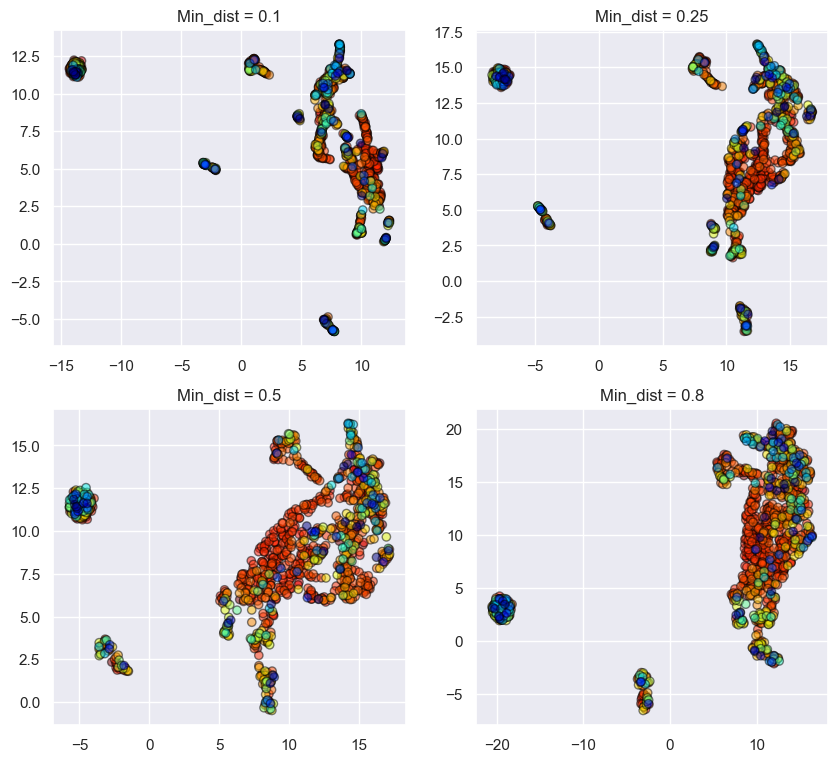

In [42]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, d in enumerate([0.1, 0.25, 0.5, 0.8]):
    
    # perform UMAP
    X_umap =  umap.UMAP(n_components=2, min_dist=d, metric='manhattan').fit_transform(X_norm)
    
    u_results=pd.DataFrame(X_umap, columns=['u1', 'u2'])
    
    # plot the results
    plt.subplot(2,2,index+1)
    plt.scatter(u_results['u1'], u_results['u2'], c=Y, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
    plt.title('Min_dist = '+ str(d))
plt.show()

Here we see that with a small min_dist UMAP manages to find small connected components and clusters. When min_dist is increased, these structures are pushed into softer and more general features, providing a better overall representation of the data while losing more detail.

c:\Users\ninag\mambaforge\envs\math\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



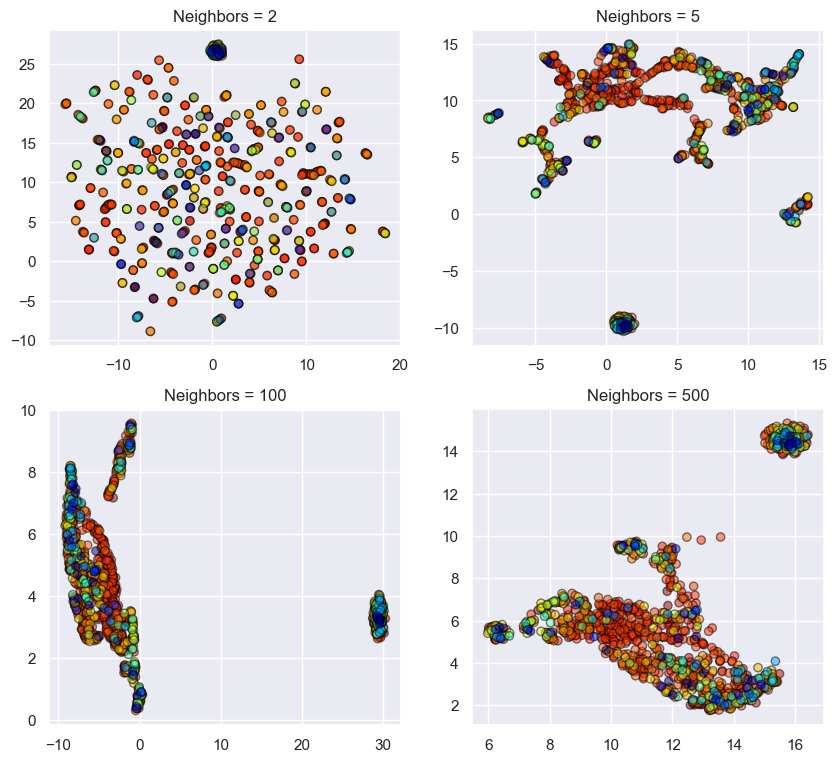

In [43]:
plt.figure(figsize = (10,5))
plt.subplots_adjust(top = 1.5)

for index, n in enumerate([2, 5, 100, 500]):

    # perform UMAP
    X_umap =  umap.UMAP(n_components=2, n_neighbors=n, min_dist=0.25, metric='manhattan').fit_transform(X_norm)
    
    u_results=pd.DataFrame(X_umap, columns=['u1', 'u2'])
    
    # plot the results
    plt.subplot(2,2,index+1)
    plt.scatter(u_results['u1'], u_results['u2'], c=Y, edgecolors='black', cmap=cm.jet_r, alpha=0.5)
    plt.title('Neighbors = '+ str(n))
plt.show()

As we can see, when neighbors = 2, the data are very disjointed, indicating that in terms of fine detail, the data are very disjointed and scattered throughout the space. As n_neighbors increases further more and more focus in placed on the overall structure of the data. 